<a href="https://colab.research.google.com/github/prantik-pdeb/GSoC2023-ML4SCI_QMLHEP/blob/main/Task_VII_Equivariant_quantum_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"In this task you are supposed to get started with equivariant quantum neural networks by implementing a Z_2 × Z_2 equivariant quantum neural network. Z_2 is a symmetry group an as an example we will generate a simple classical dataset which is respects the Z_2 x Z_2 symmetry."

1. Generate a classification dataset with two classes and two features x_1 and x_2 which respects the Z_2 x Z_2 symmetry (this corresponds to mirroring along y=x). An example can be found in the first reference paper.

2. Train a QNN to solve the classification problem

3. Train an Z_2 x Z_2 equivariant QNN to solve the classification problem and compare the results.


# Using Pennylane:

In [3]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.8 MB/s eta 0:00:00


In [4]:
import pennylane as qml
import matplotlib.pyplot as plt

In [5]:
'''Generate a classification dataset with two classes and two features x_1 and x_2
which respects the Z_2 x Z_2 symmetry (this corresponds to mirroring along y=x)'''

# Reference Paper: https://arxiv.org/pdf/2205.06217.pdf

 
import torch
import random

# Fix seeds for reproducability
torch.backends.cudnn.deterministic = True
torch.manual_seed(16)
random.seed(16)

# Create an empty board
def create_board():
    return torch.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]])


# Check for empty places on board
def possibilities(board):
    l = []
    for i in range(len(board)):
        for j in range(3):
            if board[i, j] == 0:
                l.append((i, j))
    return l


# Select a random place for the player
def random_place(board, player):
    selection = possibilities(board)
    current_loc = random.choice(selection)
    board[current_loc] = player
    return board


# Check if there is a winner by having 3 in a row
def row_win(board, player):
    for x in range(3):
        lista = []
        win = True

        for y in range(3):
            lista.append(board[x, y])

            if board[x, y] != player:
                win = False

        if win:
            break

    return win


# Check if there is a winner by having 3 in a column
def col_win(board, player):
    for x in range(3):
        win = True

        for y in range(3):
            if board[y, x] != player:
                win = False

        if win:
            break

    return win


# Check if there is a winner by having 3 along a diagonal
def diag_win(board, player):
    win1 = True
    win2 = True
    for x, y in [(0, 0), (1, 1), (2, 2)]:
        if board[x, y] != player:
            win1 = False

    for x, y in [(0, 2), (1, 1), (2, 0)]:
        if board[x, y] != player:
            win2 = False

    return win1 or win2


# Check if the win conditions have been met or if a draw has occurred
def evaluate_game(board):
    winner = None
    for player in [1, -1]:
        if row_win(board, player) or col_win(board, player) or diag_win(board, player):
            winner = player

    if torch.all(board != 0) and winner == None:
        winner = 0

    return winner


# Main function to start the game
def play_game():
    board, winner, counter = create_board(), None, 1
    while winner == None:
        for player in [1, -1]:
            board = random_place(board, player)
            counter += 1
            winner = evaluate_game(board)
            if winner != None:
                break

    return [board.flatten(), winner]


def create_dataset(size_for_each_winner):
    game_d = {-1: [], 0: [], 1: []}

    while min([len(v) for k, v in game_d.items()]) < size_for_each_winner:
        board, winner = play_game()
        if len(game_d[winner]) < size_for_each_winner:
            game_d[winner].append(board)

    res = []
    for winner, boards in game_d.items():
        res += [(board, winner) for board in boards]

    return res


NUM_TRAINING = 450
NUM_VALIDATION = 600

# Create datasets but with even numbers of each outcome
with torch.no_grad():
    dataset = create_dataset(NUM_TRAINING // 3)
    dataset_val = create_dataset(NUM_VALIDATION // 3)

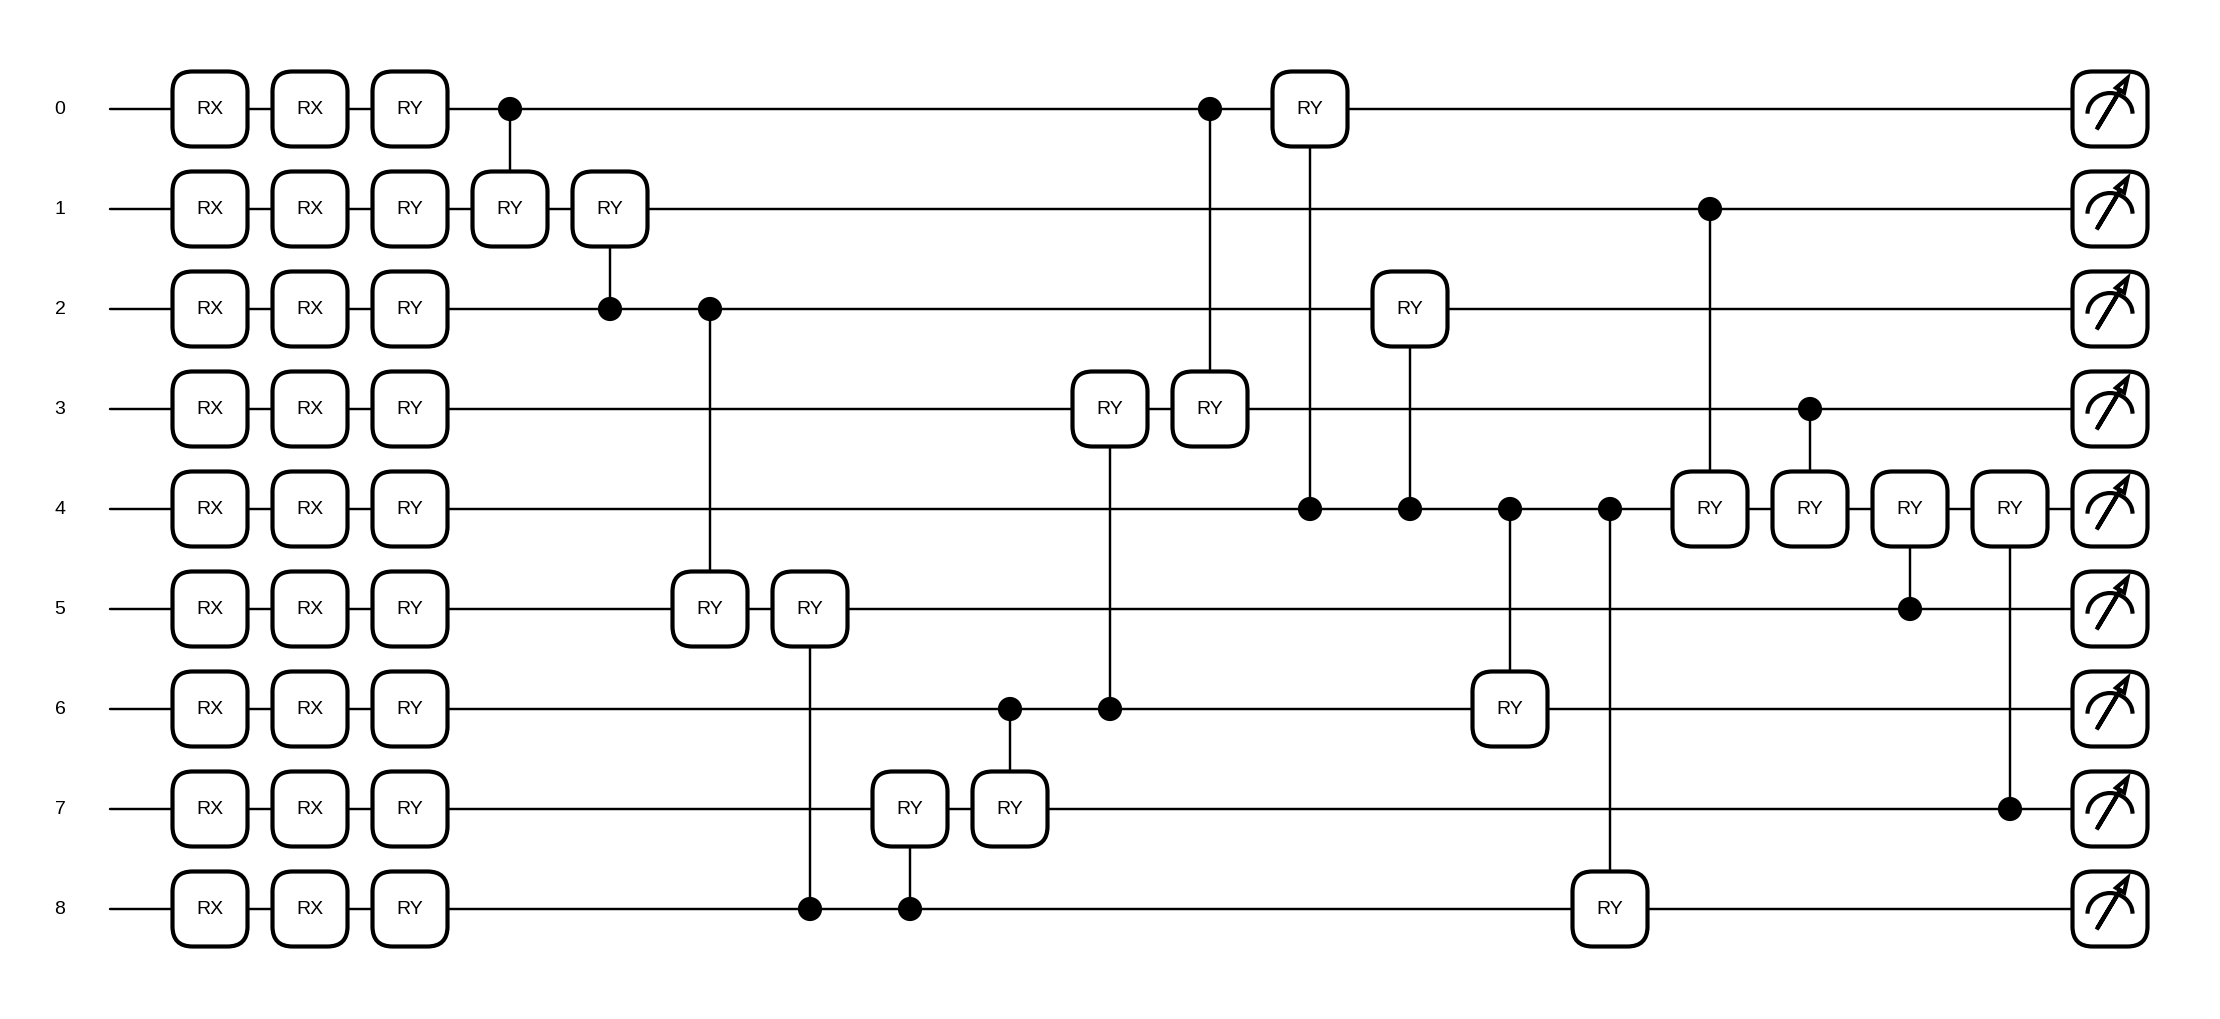

In [6]:
'''Now, create the relevant circuit expectation values that respect the 
symmetry classes we defined over the single-site and two-site measurements.'''

# Set up a nine-qubit system
dev = qml.device("default.qubit.torch", wires=9)

ob_center = qml.PauliZ(4)
ob_corner = (qml.PauliZ(0) + qml.PauliZ(2) + qml.PauliZ(6) + qml.PauliZ(8)) * (1 / 4)
ob_edge = (qml.PauliZ(1) + qml.PauliZ(3) + qml.PauliZ(5) + qml.PauliZ(7)) * (1 / 4)

# Now let's encode the data in the following qubit models, first with symmetry
@qml.qnode(dev, interface="torch")
def circuit(x, p):

    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RX(x[2], wires=2)
    qml.RX(x[3], wires=3)
    qml.RX(x[4], wires=4)
    qml.RX(x[5], wires=5)
    qml.RX(x[6], wires=6)
    qml.RX(x[7], wires=7)
    qml.RX(x[8], wires=8)

    # Centre single-qubit rotation
    qml.RX(p[0], wires=4)
    qml.RY(p[1], wires=4)

    # Corner single-qubit rotation
    qml.RX(p[2], wires=0)
    qml.RX(p[2], wires=2)
    qml.RX(p[2], wires=6)
    qml.RX(p[2], wires=8)

    qml.RY(p[3], wires=0)
    qml.RY(p[3], wires=2)
    qml.RY(p[3], wires=6)
    qml.RY(p[3], wires=8)

    # Edge single-qubit rotation
    qml.RX(p[4], wires=1)
    qml.RX(p[4], wires=3)
    qml.RX(p[4], wires=5)
    qml.RX(p[4], wires=7)

    qml.RY(p[5], wires=1)
    qml.RY(p[5], wires=3)
    qml.RY(p[5], wires=5)
    qml.RY(p[5], wires=7)

    # Entagling two-qubit gates
    # circling the edge of the board
    qml.CRY(p[6], wires=[0, 1])
    qml.CRY(p[6], wires=[2, 1])
    qml.CRY(p[6], wires=[2, 5])
    qml.CRY(p[6], wires=[8, 5])
    qml.CRY(p[6], wires=[8, 7])
    qml.CRY(p[6], wires=[6, 7])
    qml.CRY(p[6], wires=[6, 3])
    qml.CRY(p[6], wires=[0, 3])

    # To the corners from the centre
    qml.CRY(p[7], wires=[4, 0])
    qml.CRY(p[7], wires=[4, 2])
    qml.CRY(p[7], wires=[4, 6])
    qml.CRY(p[7], wires=[4, 8])

    # To the centre from the edges
    qml.CRY(p[8], wires=[1, 4])
    qml.CRY(p[8], wires=[3, 4])
    qml.CRY(p[8], wires=[5, 4])
    qml.CRY(p[8], wires=[7, 4])

    return [qml.expval(ob_center), qml.expval(ob_corner), qml.expval(ob_edge)]


fig, ax = qml.draw_mpl(circuit)([0] * 9, 18 * [0])

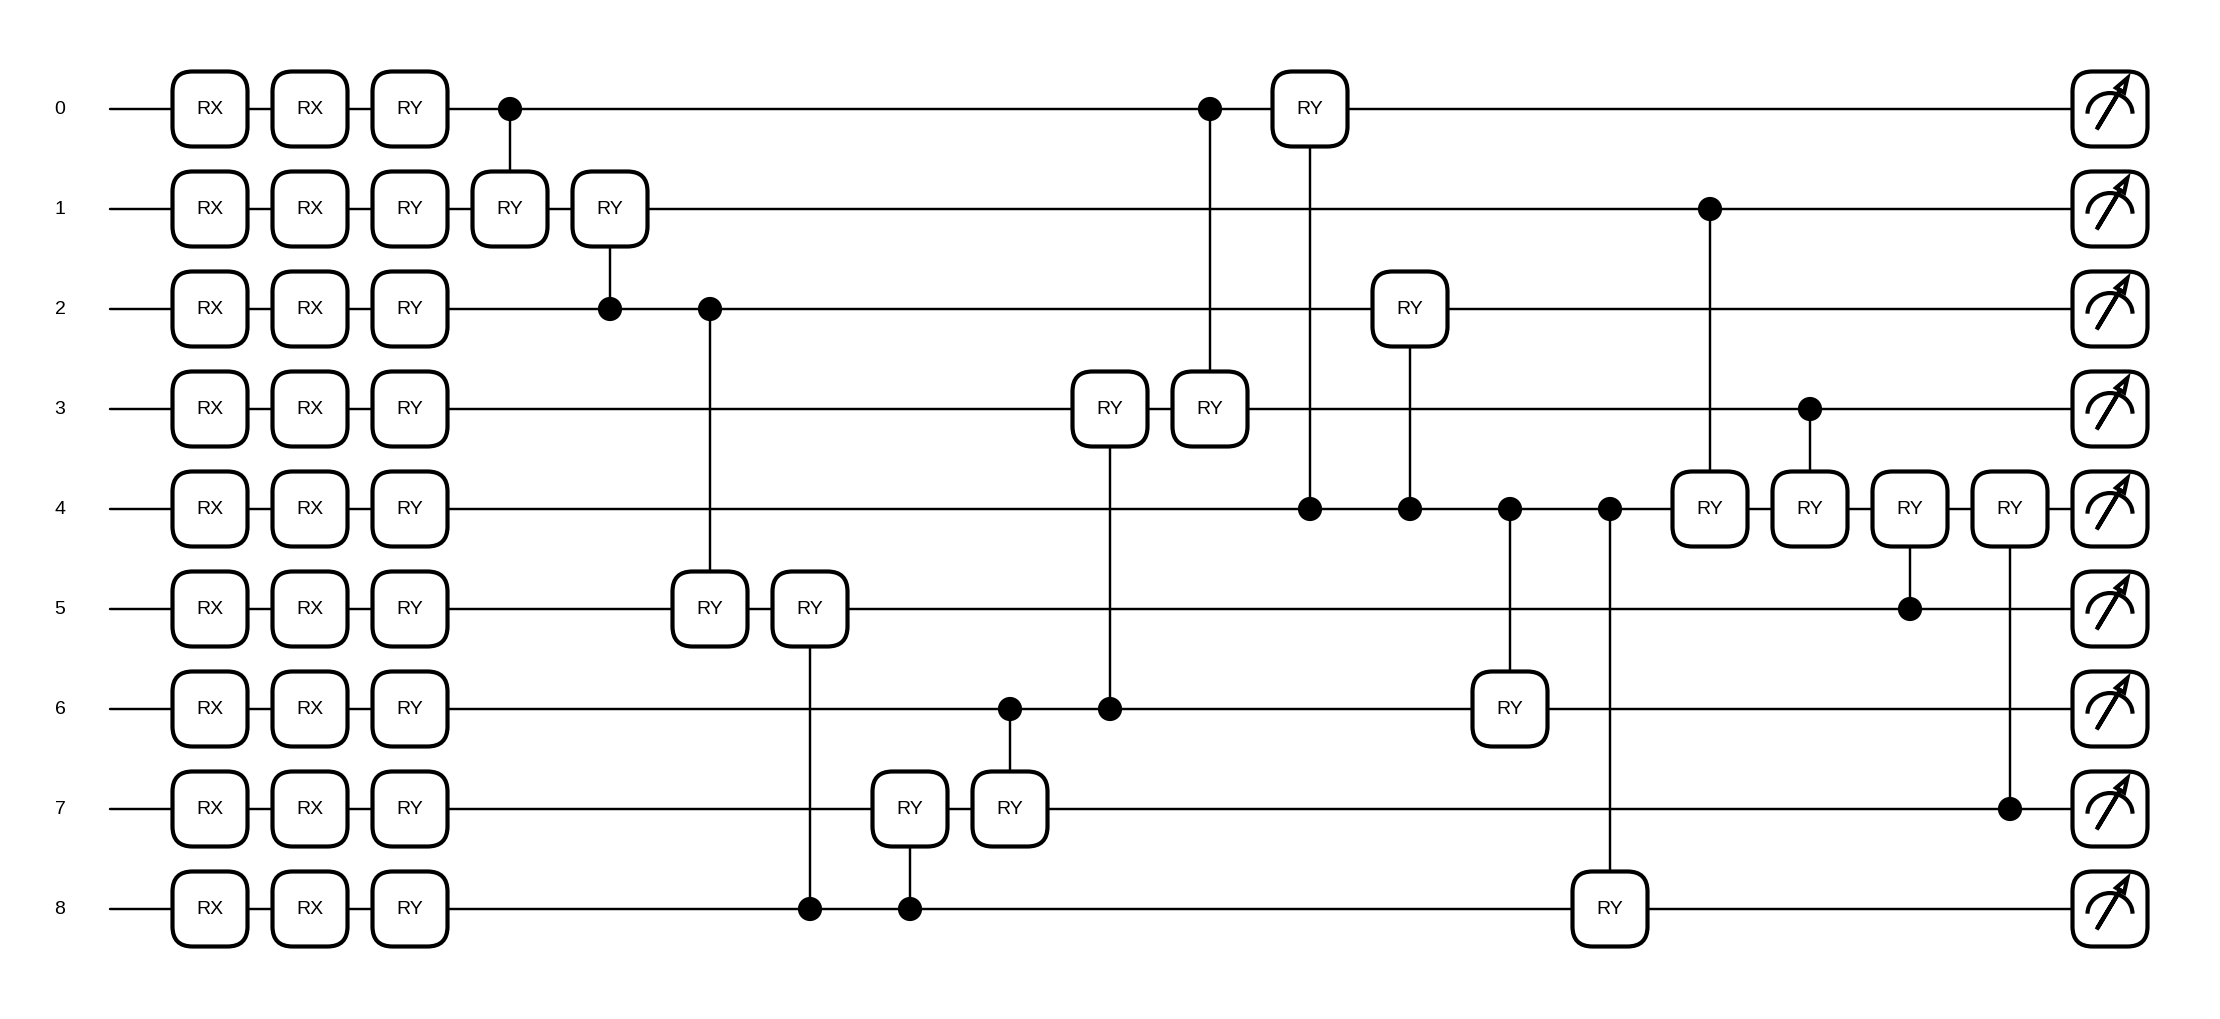

In [7]:
@qml.qnode(dev, interface="torch")
def circuit_no_sym(x, p):

    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.RX(x[2], wires=2)
    qml.RX(x[3], wires=3)
    qml.RX(x[4], wires=4)
    qml.RX(x[5], wires=5)
    qml.RX(x[6], wires=6)
    qml.RX(x[7], wires=7)
    qml.RX(x[8], wires=8)

    # Centre single-qubit rotation
    qml.RX(p[0], wires=4)
    qml.RY(p[1], wires=4)

    # Note in this circuit the parameters aren't all the same.
    # Previously they were identical to ensure they were applied
    # as one combined gate. The fact they can all vary independently
    # here means we aren't respecting the symmetry.

    # Corner single-qubit rotation
    qml.RX(p[2], wires=0)
    qml.RX(p[3], wires=2)
    qml.RX(p[4], wires=6)
    qml.RX(p[5], wires=8)

    qml.RY(p[6], wires=0)
    qml.RY(p[7], wires=2)
    qml.RY(p[8], wires=6)
    qml.RY(p[9], wires=8)

    # Edge single-qubit rotation
    qml.RX(p[10], wires=1)
    qml.RX(p[11], wires=3)
    qml.RX(p[12], wires=5)
    qml.RX(p[13], wires=7)

    qml.RY(p[14], wires=1)
    qml.RY(p[15], wires=3)
    qml.RY(p[16], wires=5)
    qml.RY(p[17], wires=7)

    # Entagling two-qubit gates
    # circling the edge of the board
    qml.CRY(p[18], wires=[0, 1])
    qml.CRY(p[19], wires=[2, 1])
    qml.CRY(p[20], wires=[2, 5])
    qml.CRY(p[21], wires=[8, 5])
    qml.CRY(p[22], wires=[8, 7])
    qml.CRY(p[23], wires=[6, 7])
    qml.CRY(p[24], wires=[6, 3])
    qml.CRY(p[25], wires=[0, 3])

    # To the corners from the centre
    qml.CRY(p[26], wires=[4, 0])
    qml.CRY(p[27], wires=[4, 2])
    qml.CRY(p[28], wires=[4, 6])
    qml.CRY(p[29], wires=[4, 8])

    # To the centre from the edges
    qml.CRY(p[30], wires=[1, 4])
    qml.CRY(p[31], wires=[3, 4])
    qml.CRY(p[32], wires=[5, 4])
    qml.CRY(p[33], wires=[7, 4])

    return [qml.expval(ob_center), qml.expval(ob_corner), qml.expval(ob_edge)]


fig, ax = qml.draw_mpl(circuit_no_sym)([0] * 9, [0] * 34)

In [8]:
import math

def encode_game(game):
    board, res = game
    x = board * (2 * math.pi) / 3
    if res == 1:
        y = [-1, -1, 1]
    elif res == -1:
        y = [1, -1, -1]
    else:
        y = [-1, 1, -1]
    return x, y

In [9]:
# calculate the mean square error for this classification problem
# loss function
def cost_function(params, input, target):
    output = torch.stack([circuit(x, params) for x in input])
    vec = output - target
    sum_sqr = torch.sum(vec * vec, dim=1)
    return torch.mean(sum_sqr)

In [10]:
# train symmetry-preserving circuit on the data.

from torch import optim
import numpy as np

params = 0.01 * torch.randn(9)
params.requires_grad = True
opt = optim.Adam([params], lr=1e-2)


max_epoch = 30
max_step = 30
batch_size = 10

encoded_dataset = list(zip(*[encode_game(game) for game in dataset]))
encoded_dataset_val = list(zip(*[encode_game(game) for game in dataset_val]))


def accuracy(p, x_val, y_val):
    with torch.no_grad():
        y_val = torch.tensor(y_val)
        y_out = torch.stack([circuit(x, p) for x in x_val])
        acc = torch.sum(torch.argmax(y_out, axis=1) == torch.argmax(y_val, axis=1))
        return acc / len(x_val)


print(f"accuracy without training = {accuracy(params, *encoded_dataset_val)}")

x_dataset = torch.stack(encoded_dataset[0])
y_dataset = torch.tensor(encoded_dataset[1], requires_grad=False)

saved_costs_sym = []
saved_accs_sym = []
for epoch in range(max_epoch):
    rand_idx = torch.randperm(len(x_dataset))
    # Shuffled dataset
    x_dataset = x_dataset[rand_idx]
    y_dataset = y_dataset[rand_idx]

    costs = []

    for step in range(max_step):
        x_batch = x_dataset[step * batch_size : (step + 1) * batch_size]
        y_batch = y_dataset[step * batch_size : (step + 1) * batch_size]

        def opt_func():
            opt.zero_grad()
            loss = cost_function(params, x_batch, y_batch)
            costs.append(loss.item())
            loss.backward()
            return loss

        opt.step(opt_func)

    cost = np.mean(costs)
    saved_costs_sym.append(cost)

    if (epoch + 1) % 1 == 0:
        # Compute validation accuracy
        acc_val = accuracy(params, *encoded_dataset_val)
        saved_accs_sym.append(acc_val)

        res = [epoch + 1, cost, acc_val]
        print("Epoch: {:2d} | Loss: {:3f} | Validation accuracy: {:3f}".format(*res))

accuracy without training = 0.2383333295583725
Epoch:  1 | Loss: 2.996221 | Validation accuracy: 0.153333
Epoch:  2 | Loss: 2.838961 | Validation accuracy: 0.415000
Epoch:  3 | Loss: 2.721652 | Validation accuracy: 0.535000
Epoch:  4 | Loss: 2.686487 | Validation accuracy: 0.553333
Epoch:  5 | Loss: 2.608699 | Validation accuracy: 0.548333
Epoch:  6 | Loss: 2.648471 | Validation accuracy: 0.591667
Epoch:  7 | Loss: 2.630698 | Validation accuracy: 0.585000
Epoch:  8 | Loss: 2.544674 | Validation accuracy: 0.585000
Epoch:  9 | Loss: 2.630653 | Validation accuracy: 0.570000
Epoch: 10 | Loss: 2.595081 | Validation accuracy: 0.576667
Epoch: 11 | Loss: 2.586225 | Validation accuracy: 0.578333
Epoch: 12 | Loss: 2.600443 | Validation accuracy: 0.578333
Epoch: 13 | Loss: 2.652541 | Validation accuracy: 0.576667
Epoch: 14 | Loss: 2.585265 | Validation accuracy: 0.580000
Epoch: 15 | Loss: 2.598611 | Validation accuracy: 0.580000
Epoch: 16 | Loss: 2.551466 | Validation accuracy: 0.580000
Epoch: 17

In [11]:
#Now we train the non-symmetry preserving circuit.
params = 0.01 * torch.randn(34)
params.requires_grad = True
opt = optim.Adam([params], lr=1e-2)

# calculate mean square error for this classification problem


def cost_function_no_sym(params, input, target):
    output = torch.stack([circuit_no_sym(x, params) for x in input])
    vec = output - target
    sum_sqr = torch.sum(vec * vec, dim=1)
    return torch.mean(sum_sqr)


max_epoch = 30
max_step = 30
batch_size = 10

encoded_dataset = list(zip(*[encode_game(game) for game in dataset]))
encoded_dataset_val = list(zip(*[encode_game(game) for game in dataset_val]))


def accuracy_no_sym(p, x_val, y_val):
    with torch.no_grad():
        y_val = torch.tensor(y_val)
        y_out = torch.stack([circuit_no_sym(x, p) for x in x_val])
        acc = torch.sum(torch.argmax(y_out, axis=1) == torch.argmax(y_val, axis=1))
        return acc / len(x_val)


print(f"accuracy without training = {accuracy_no_sym(params, *encoded_dataset_val)}")


x_dataset = torch.stack(encoded_dataset[0])
y_dataset = torch.tensor(encoded_dataset[1], requires_grad=False)

saved_costs = []
saved_accs = []
for epoch in range(max_epoch):
    rand_idx = torch.randperm(len(x_dataset))
    # Shuffled dataset
    x_dataset = x_dataset[rand_idx]
    y_dataset = y_dataset[rand_idx]

    costs = []

    for step in range(max_step):
        x_batch = x_dataset[step * batch_size : (step + 1) * batch_size]
        y_batch = y_dataset[step * batch_size : (step + 1) * batch_size]

        def opt_func():
            opt.zero_grad()
            loss = cost_function_no_sym(params, x_batch, y_batch)
            costs.append(loss.item())
            loss.backward()
            return loss

        opt.step(opt_func)

    cost = np.mean(costs)
    saved_costs.append(costs)

    if (epoch + 1) % 1 == 0:
        # Compute validation accuracy
        acc_val = accuracy_no_sym(params, *encoded_dataset_val)
        saved_accs.append(acc_val)

        res = [epoch + 1, cost, acc_val]
        print("Epoch: {:2d} | Loss: {:3f} | Validation accuracy: {:3f}".format(*res))

accuracy without training = 0.2633333206176758
Epoch:  1 | Loss: 3.009900 | Validation accuracy: 0.215000
Epoch:  2 | Loss: 2.853414 | Validation accuracy: 0.348333
Epoch:  3 | Loss: 2.765294 | Validation accuracy: 0.400000
Epoch:  4 | Loss: 2.731975 | Validation accuracy: 0.425000
Epoch:  5 | Loss: 2.726319 | Validation accuracy: 0.421667
Epoch:  6 | Loss: 2.672388 | Validation accuracy: 0.440000
Epoch:  7 | Loss: 2.648272 | Validation accuracy: 0.461667
Epoch:  8 | Loss: 2.609692 | Validation accuracy: 0.466667
Epoch:  9 | Loss: 2.615942 | Validation accuracy: 0.471667
Epoch: 10 | Loss: 2.641968 | Validation accuracy: 0.476667
Epoch: 11 | Loss: 2.587902 | Validation accuracy: 0.486667
Epoch: 12 | Loss: 2.620730 | Validation accuracy: 0.475000
Epoch: 13 | Loss: 2.603438 | Validation accuracy: 0.471667
Epoch: 14 | Loss: 2.570574 | Validation accuracy: 0.513333
Epoch: 15 | Loss: 2.589663 | Validation accuracy: 0.491667
Epoch: 16 | Loss: 2.522613 | Validation accuracy: 0.481667
Epoch: 17

<ipython-input-12-3ed66a2f00a0>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


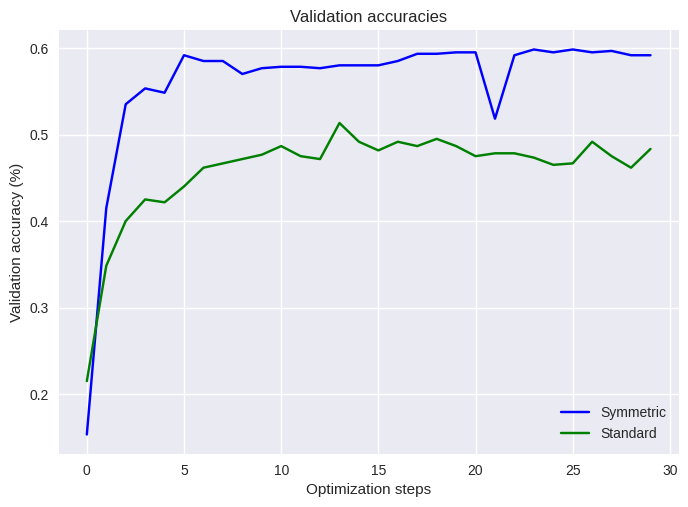

In [12]:
from matplotlib import pyplot as plt

plt.style.use("seaborn")
plt.title("Validation accuracies")
plt.plot(saved_accs_sym, "b", label="Symmetric")
plt.plot(saved_accs, "g", label="Standard")

plt.ylabel("Validation accuracy (%)")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

# References:

1. Nguyen, Quynh T., et al. "Theory for equivariant quantum neural networks." arXiv preprint arXiv:2210.08566 (2022).

2. Meyer, Johannes Jakob, et al. "Exploiting symmetry in variational quantum machine learning." PRX Quantum 4.1 (2023): 010328.

3. Bronstein, Michael M., et al. "Geometric deep learning: Grids, groups, graphs, geodesics, and gauges." arXiv preprint arXiv:2104.13478 (2021).

4. Cohen, Taco, and Max Welling. "Group equivariant convolutional networks." International conference on machine learning. PMLR, 2016.

5. “Introduction to Geometric Quantum Machine Learning — PennyLane.” Pennylane.ai, https://pennylane.ai/qml/demos/tutorial_geometric_qml.html Accessed 1 Apr. 2023.